Create U-net for brain segmentation

The provided is a folder of T2 weighted axial brain slices with tissue labels. 

Process:

(1)Build a bespoke Pytorch dataset for these examples. And to one hot encode the labels and convert to PyTorch tensors of the correct type and shape

(2)Create separate DataLoaders for train and validation sets
create the Unet to segment this data

(3)try replacing the maxpools above with strided convolutions and the dropout and instead including a batchnorm

(4)train the network using the dice and cross entropy loss, report train and validation performance

(5)optimise the network to get the best performance

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torch.optim as optim

In [ ]:

# edit this path to match where you put your data
path_relative_to_drive='Colab Notebooks/Colab_Data/mrimages/'
data_path=path_relative_to_drive+'mridata/'

full_path=os.path.join('/content/drive/My Drive/', data_path)

# read in the labels for train test and val
# these are scv files with 2 labels for each image (age at birth and age at scan)
meta_train=pd.read_csv(os.path.join('/content/drive/My Drive/', path_relative_to_drive + 'data_train_AML.csv'))
meta_valid=pd.read_csv(os.path.join('/content/drive/My Drive/', path_relative_to_drive + 'data_valid_AML.csv'))

print('number of train samples', len(meta_train))
print('number of validation samples', len(meta_valid))

number of train samples 324
number of validation samples 32


/content/drive/My Drive/Colab Notebooks/Colab_Data/mrimages/mridata/1_t2w.npy


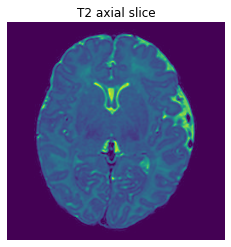

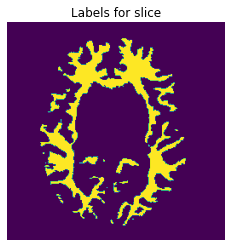

image shape (4, 256, 256) [0. 1.]


In [ ]:
def load_data(fullpath, meta,idx):
  ''' example of how to load and normalise data '''
  image_path=os.path.join(full_path,meta['image_name'][idx].replace(".jpg", ".npy"))
  label_path=os.path.join(full_path,meta['label_name'][idx].replace(".jpg", ".npy"))
  print(image_path)

  image=np.load(image_path) 
  # the label file should be 
  label=np.load(label_path) 

  # normalise into range 0-1
  if np.max(image)-np.min(image) !=0:
    image=(image-np.min(image))/(np.max(image)-np.min(image))
 
  return image,label

example_im, example_lab=load_data(full_path, meta_train,0)

plt.imshow(example_im); plt.axis('off')
plt.title('T2 axial slice')
plt.show()

plt.imshow(example_lab[3]); plt.axis('off')
plt.title('Labels for slice')
plt.show()

print('image shape',example_lab.shape,np.unique(example_lab))

In [ ]:
# CONVERT TO TORCH TENSORS of shape (C,H,W) AND ONE HOT ENCODE THE LABELS
LABELS_DICT = {0: 'background', 1: 'csf', 2: 'cortical gray matter', 3: 'white matter'}


class BrainSegmentationDataset(torch.utils.data.Dataset): 
    
    # initialise the class based on the folder containing the data and the project dataframe
    def __init__(self, folder='', meta='', transform=None): 
        
       # initialise the paths to the data folder, the data frame and define the transform operations
        self.folder = folder
        self.meta = meta
        self.transform=transform
        
    
    def __len__(self):
         # return the number of examples in the dataset
        return len(self.meta)
    
    def __getitem__(self, idx):
        
        # load images 
        image_path=os.path.join(self.folder,self.meta['image_name'][idx].replace(".jpg", ".npy"))
        label_path=os.path.join(self.folder,self.meta['label_name'][idx].replace(".jpg", ".npy"))

        image=np.load(image_path)
        # convert one hot encoded label to tensor
        label=torch.from_numpy(np.load(label_path)).to(torch.int64)


        if self.transform:
            # convert image to tensor and normalise
            img_tensor = self.transform(image)
        

        sample = img_tensor, label

        
            
        return sample

length 324


Text(0.5, 1.0, 'white matter')

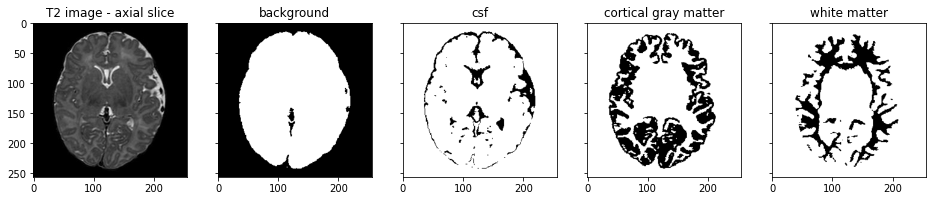

In [ ]:
# testing out the dataset class

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

# Create an instance of the BrainSegmentationDataset class by calling the constructor
ds = BrainSegmentationDataset(full_path,meta_train,transform) # then we create the dataset 

# check that the length is correct
print('length',ds.__len__())

# return index 0 from getitem
example_im,ex_label=ds.__getitem__(0)

# plot 

fig, ax = plt.subplots(ncols=5, sharex=True, sharey=True,
                       figsize=(16, 8))
ax[0].imshow(example_im[0,:,:], cmap=plt.cm.gray)
ax[0].set_title('T2 image - axial slice')
ax[1].imshow(ex_label[0,:,:], cmap=plt.cm.binary)
ax[1].set_title(LABELS_DICT[0])
ax[2].imshow(ex_label[1,:,:], cmap=plt.cm.binary)
ax[2].set_title(LABELS_DICT[1])
ax[3].imshow(ex_label[2,:,:], cmap=plt.cm.binary)
ax[3].set_title(LABELS_DICT[2])
ax[4].imshow(ex_label[3,:,:], cmap=plt.cm.binary)
ax[4].set_title( LABELS_DICT[3])

In [ ]:
# train loader batch size 16
train_dataset = BrainSegmentationDataset(full_path,meta_train,transform) # then create the dataset 
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True)

# validation loader batch size 32 (all validation images)
valid_dataset = BrainSegmentationDataset(full_path,meta_valid,transform) # then create the dataset 
valid_loader = DataLoader(valid_dataset, batch_size = 32, shuffle = False)

im_batch, lab_batch = next(iter(train_loader)) # get a batch
print('batch shape', im_batch.shape) 

batch shape torch.Size([16, 1, 256, 256])


In [ ]:
# STRUDED CONVOLUTIONS AND BATHNORM INSTEAD OF DROPOUT

# define U-net double conv with striding
def double_conv(in_channels, out_channels, s=1, padding=1):
    ''' adding s=stride '''
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=padding),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=padding),
        nn.ReLU(inplace=True)
    )


class UNet2(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.dconv_down1 = double_conv(1, 8)
        self.strided_conv1=nn.Conv2d(8, 8, stride=2,kernel_size=3, padding=1)
        self.dconv_down2 = double_conv(8, 16)
        self.strided_conv2=nn.Conv2d(16, 16, stride=2,kernel_size=3, padding=1)
        self.dconv_down3 = double_conv(16, 32)
        self.strided_conv3=nn.Conv2d(32, 32, stride=2,kernel_size=3, padding=1)
        self.dconv_down4 = double_conv(32, 64)
        self.strided_conv4=nn.Conv2d(64, 64, stride=2,kernel_size=3, padding=1)
        self.dconv_down5 = double_conv(64, 128)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.dconv_up4 = double_conv(64 + 128, 64)
        self.dconv_up3 = double_conv(32 + 64, 32)
        self.dconv_up2 = double_conv(16 + 32, 16)
        self.dconv_up1 = double_conv(8 + 16, 8)

        self.conv_last = nn.Conv2d(8, 4, 1)

    def forward(self, x):
        
        #######   ENCODER ###############
        
        conv1 = self.dconv_down1(x)
        x = self.strided_conv1(conv1)
        conv2 = self.dconv_down2(x)
        x = self.strided_conv2(conv2)
        conv3 = self.dconv_down3(x)
        x = self.strided_conv3(conv3)
        conv4 = self.dconv_down4(x)
        x = self.strided_conv4(conv4)

        # bottleneck 
        conv5 = self.dconv_down5(x)
        #######   DECODER ###############
        deconv4 = self.upsample(conv5)
        deconv4 = torch.cat([deconv4, conv4], dim=1)
        deconv4  = self.dconv_up4(deconv4)

        deconv3 = self.upsample(deconv4)
        deconv3 = torch.cat([deconv3, conv3], dim=1)
        deconv3  = self.dconv_up3(deconv3)
        deconv2 = self.upsample(deconv3)
        deconv2 = torch.cat([deconv2, conv2], dim=1)
        deconv2  = self.dconv_up2(deconv2)
 
        deconv1 = self.upsample(deconv2)
        deconv1 = torch.cat([deconv1, conv1], dim=1)
        deconv1  = self.dconv_up1(deconv1)

        return F.softmax(self.conv_last(deconv1),dim=1) # need softmax for dice calculation (hard threshold on labels)

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print(device) 

cpu


In [ ]:
my_unet = UNet2()
my_unet = my_unet.to(device) 

# implementing adam optimiser
optimizer = optim.Adam(my_unet.parameters(), lr=0.001)

In [ ]:
# using dice loss from   https://github.com/kevinzakka/pytorch-goodies/blob/master/losses.py

def dice_coeff(pred, target):
   

    epsilon = 10e-8
    dims = (0,) + tuple(range(2, target.ndimension()))
    intersection = torch.sum(pred * target, dims)
    cardinality = torch.sum(pred + target, dims)
    
    dice = (2. * intersection / (cardinality + epsilon))
    dice_loss=dice.mean()

    return dice_loss

In [ ]:
epochs=20
mean_train_dice=[]
mean_val_dice=[]

for epoch in range(epochs):

    ##########
    # Train
    ##########
    
    my_unet.train() 
    train_dice= []

    for i, (data, label) in enumerate(train_loader):
        data = data.to(device)
        label= label.to(device)

        optimizer.zero_grad() 

        pred = my_unet(data)
        # just training with cross entropy for now
        err = 1- dice_coeff(pred, label) 
        # -------------------------------------------------------------------------------------------------------------------

        err.backward()
        optimizer.step()
        
        dice_value=dice_coeff(pred, label).item()

        pred_detached=pred[1,2,:,:].data.cpu().numpy()
        
        print('[{:d}/{:d}][{:d}/{:d}] Dice: {:.4f} '
              .format(epoch, epochs, i, len(train_loader), dice_value))

        
        
        train_dice.append(dice_value)
      

    # #############
    # # Validation
    # #############
    
    # set network to eval prior to training loop 
    my_unet.eval()
    val_dice= []
    for i, (data, label) in enumerate(valid_loader):
        data=data.to(device)
        label=label.to(device)     

        pred = my_unet(data)
        
        err = 1-dice_coeff(pred, label) 
       
        val_dice.append(dice_coeff(pred, label).item())

        
    mean_val_dice.append(np.mean(val_dice))
    mean_train_dice.append(np.mean(train_dice))

   

    print('Val Dice: {}, Train Dice: {:.4f}'.format(np.mean(mean_val_dice),np.mean(train_dice)))

[0/20][0/21] Dice: 0.2167 
[0/20][1/21] Dice: 0.2138 
[0/20][2/21] Dice: 0.2163 
[0/20][3/21] Dice: 0.2166 
[0/20][4/21] Dice: 0.2177 
[0/20][5/21] Dice: 0.2166 
[0/20][6/21] Dice: 0.2188 
[0/20][7/21] Dice: 0.2197 
[0/20][8/21] Dice: 0.2221 
[0/20][9/21] Dice: 0.2246 
[0/20][10/21] Dice: 0.2309 
[0/20][11/21] Dice: 0.2376 
[0/20][12/21] Dice: 0.2513 
[0/20][13/21] Dice: 0.2675 
[0/20][14/21] Dice: 0.2941 
[0/20][15/21] Dice: 0.3271 
[0/20][16/21] Dice: 0.2199 
[0/20][17/21] Dice: 0.3122 
[0/20][18/21] Dice: 0.2770 
[0/20][19/21] Dice: 0.3065 
[0/20][20/21] Dice: 0.3477 
Val Dice: 0.18892820179462433, Train Dice: 0.2502
[1/20][0/21] Dice: 0.1876 
[1/20][1/21] Dice: 0.3638 
[1/20][2/21] Dice: 0.3510 
[1/20][3/21] Dice: 0.3552 
[1/20][4/21] Dice: 0.3684 
[1/20][5/21] Dice: 0.3462 
[1/20][6/21] Dice: 0.3689 
[1/20][7/21] Dice: 0.3596 
[1/20][8/21] Dice: 0.3609 
[1/20][9/21] Dice: 0.3692 
[1/20][10/21] Dice: 0.3715 
[1/20][11/21] Dice: 0.3649 
[1/20][12/21] Dice: 0.3707 
[1/20][13/21] Dice

0 (1, 4, 256, 256) (1, 4, 256, 256) 65536 40941.0


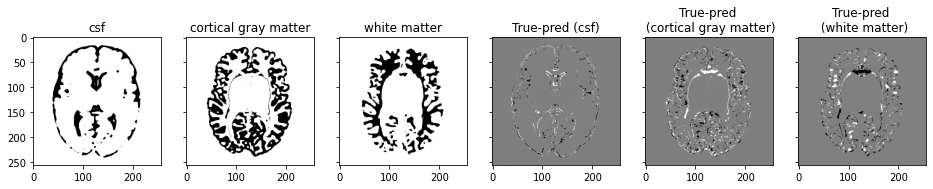

1 (1, 4, 256, 256) (1, 4, 256, 256) 65536 43486.0


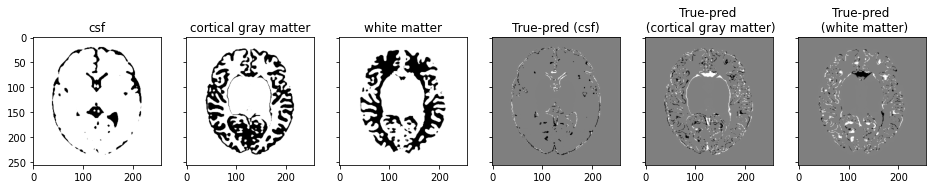

2 (1, 4, 256, 256) (1, 4, 256, 256) 65536 45058.0


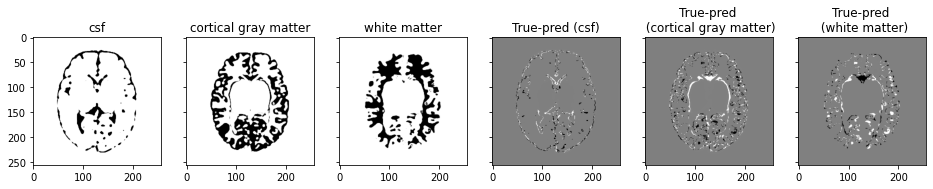

3 (1, 4, 256, 256) (1, 4, 256, 256) 65536 40485.0


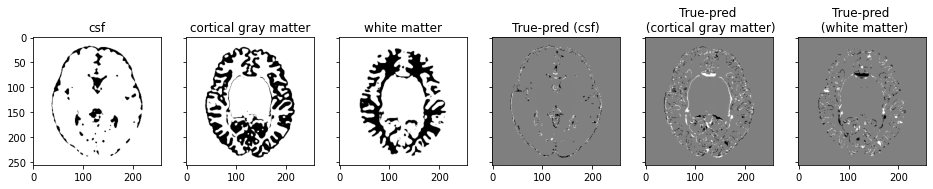

4 (1, 4, 256, 256) (1, 4, 256, 256) 65536 49525.0


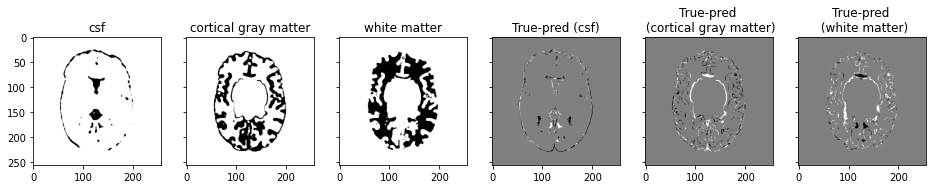

In [ ]:
# plot all va;idation predictions against ground truth 
valid_loader = DataLoader(valid_dataset, batch_size = 1, shuffle = False)

# set network to eval prior to training loop 
my_unet.eval()
val_dice= []
for i, (data, label) in enumerate(valid_loader):
    data=data.to(device)
    label=label.to(device)     

    pred = my_unet(data)
    
    DICE= dice_coeff(pred, label) 

    y_true = label.data.cpu().numpy()
    y_pred = pred.data.cpu().numpy()

    print(i,y_true.shape,y_pred.shape,y_pred.shape[2]*y_pred.shape[3], np.sum(y_pred[y_pred==1]))
    

    fig, ax = plt.subplots(ncols=6, sharex=True, sharey=True,
                       figsize=(16, 8))
    ax[0].imshow(y_pred[0,1,:,:], cmap=plt.cm.binary)
    ax[0].set_title(LABELS_DICT[1])
    ax[1].imshow(y_pred[0,2,:,:], cmap=plt.cm.binary)
    ax[1].set_title(LABELS_DICT[2])
    ax[2].imshow(y_pred[0,3,:,:], cmap=plt.cm.binary)
    ax[2].set_title( LABELS_DICT[3])
    ax[3].imshow(y_true[0,1,:,:]-y_pred[0,1,:,:], cmap=plt.cm.binary)
    ax[3].set_title('True-pred (' + LABELS_DICT[1] +')')
    ax[4].imshow(y_true[0,2,:,:]-y_pred[0,2,:,:], cmap=plt.cm.binary)
    ax[4].set_title('True-pred \n (' + LABELS_DICT[2] +')')
    ax[5].imshow(y_true[0,3,:,:]-y_pred[0,3,:,:], cmap=plt.cm.binary)
    ax[5].set_title( 'True-pred \n (' + LABELS_DICT[3] +')')
    plt.show()

    if i> 3:
      break